# Ablation Study of DNN Architectures

Choosing an architecture is challenging.  In this notebook, we train a fully-connected network with various widths and depths and compare the function approximation quality.  

There are many other choices we have not considered and you are welcome to explore on your own:

*   Choice of loss function, optimizer, and acitvation function
*   Variable widths through the network (e.g., a network that gets wider and then narrower vs. the opposite)
* More complicated data (e.g., higher dimensional, more difficult one-dimensional function to approximate, etc.)
* and many, many more!












## Step 1: Import Packages

We start by importing the necessary packages to run our code.  We are installing the following packages:

   * deep learning toolbox [Pytorch](https://pytorch.org/)
   * visualization toolbox [Matplotlib](https://matplotlib.org/)
   * DNN101 repository [https://github.com/elizabethnewman/dnn101](https://github.com/elizabethnewman/dnn101).

In [ ]:
!python -m pip install git+https://github.com/elizabethnewman/dnn101.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/elizabethnewman/dnn101.git to /tmp/pip-req-build-rdsa4ita
  Running command git clone --filter=blob:none --quiet https://github.com/elizabethnewman/dnn101.git /tmp/pip-req-build-rdsa4ita
  Resolved https://github.com/elizabethnewman/dnn101.git to commit 8ecf3fd6f27a62aff6511b45640ebbe4a855b219
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 kB 1.7 MB/s eta 0:00:00
  Created wheel for dnn101: filename=dnn101-0.0.1-py3-none-any.whl size=23825 sha256=d0d62287dafc9e00bf183f71a6ce1b4f263cd5d2b43130c405e527096ab460ce
  Stored in directory: /tmp/pip-ephem-wheel-cache-wo6cfkmp/wheels/bc/30/5c/ccf721c1147a380f4c89727bd939672fe042f5e41f996bbce5
Successfully built dnn101


In [ ]:
import dnn101
import torch
import torch.nn as nn
import matplotlib as mpl
import matplotlib.pyplot as plt

## Step 2: Create the Data

We will use a 1D regression problem as a simple starting point.

In [ ]:
from dnn101.regression import DNN101DataRegression1D

# set seed for reproducibility
torch.manual_seed(123)

# data parameters
n_train = 2000      # number of training points
n_val   = 100       # number of validation points
n_test  = 100       # number of test points
sigma   = 0.2       # noise level


# function to approximate
f = lambda x: torch.sin(x)
domain  = [-3, 3]   # domain of function
dataset = DNN101DataRegression1D(f, domain, noise_level=sigma)

# generate data
x, y = dataset.generate_data(n_train + n_val + n_test)
(x_train, y_train), (x_val, y_val), (x_test, y_test) = dataset.split_data(x, y, n_train=n_train, n_val=n_val)

# plot data
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['lines.linewidth'] = 8
mpl.rcParams['font.size'] = 10

dataset.plot_data(x_train, y_train, x_val, y_val, x_test, y_test)
plt.show()
mpl.rcParams.update(mpl.rcParamsDefault)

### Train with Different Architectures

Here, we compare training a network with various widths and depths.  There are many other parameters with which to play, we limit ourselves to only two.  This is an example of how hard it is to determine the optimal architecture.

In [ ]:
from copy import deepcopy

# import training
from dnn101.utils import evaluate, train

# choose candidate weights and depths
widths = 2 ** torch.arange(1, 6)
depths = 2 ** torch.arange(0, 6)
activation = nn.Tanh()
max_iter = 10

# storing results
results = dict()
nets = dict()

for i, wi in enumerate(widths):
    for j, dj in enumerate(depths):
        # set seed for reproducibility
        torch.manual_seed(42)
        
        # build network with different depth and width
        layers = (nn.Linear(x_train.shape[1], wi), activation)
        for _ in range(dj):
            layers += (nn.Linear(wi, wi), activation)
        layers += (nn.Linear(wi, y_train.shape[1]),)

        net = nn.Sequential(*layers)

        # loss and optimizer
        loss = torch.nn.MSELoss()        
        optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)


        # store and print results
        values = torch.zeros(max_iter + 1, 3)

        loss_train, _ = evaluate(net, loss, (x_train, y_train))
        loss_val, _ = evaluate(net, loss, (x_val, y_val))
        values[0] = torch.tensor([-1, loss_train, loss_val])
        

        # ============================================================================ #
        for my_iter in range(max_iter):
            # training step
            loss_running, _ = train(net, loss, (x_train, y_train), optimizer)

            # re-evaluate
            loss_train, _ = evaluate(net, loss, (x_train, y_train))
            loss_val, _ = evaluate(net, loss, (x_val, y_val))

            # store and print or plot results
            values[my_iter + 1] = torch.tensor([my_iter, loss_train, loss_val])

        results[i, j] = values
        nets[i, j] = deepcopy(net)


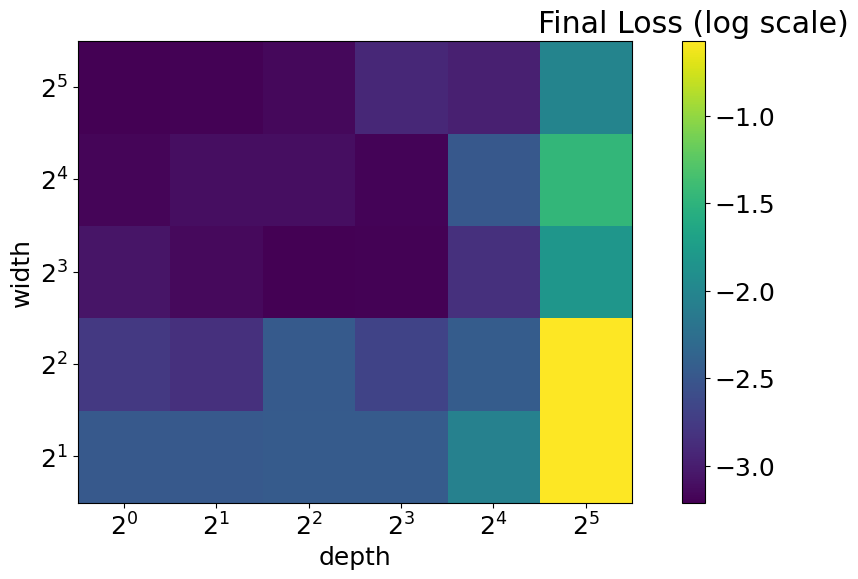

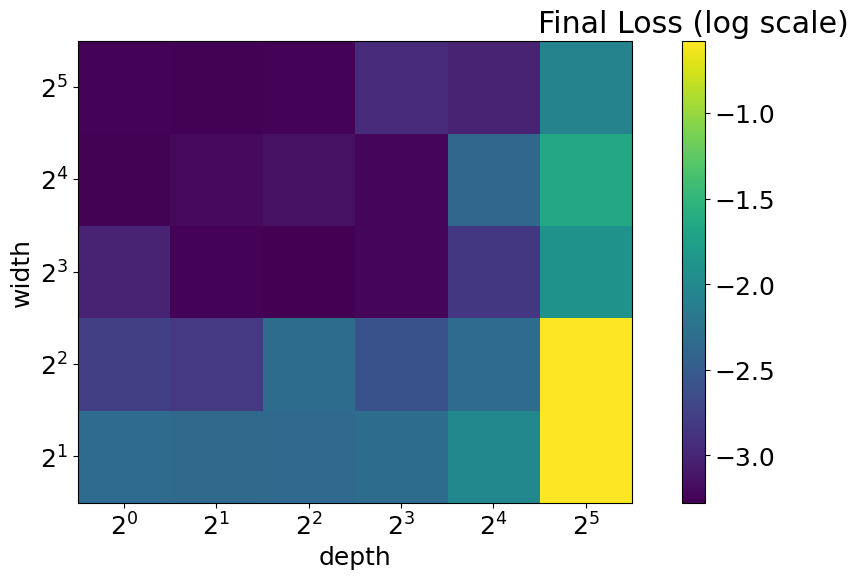

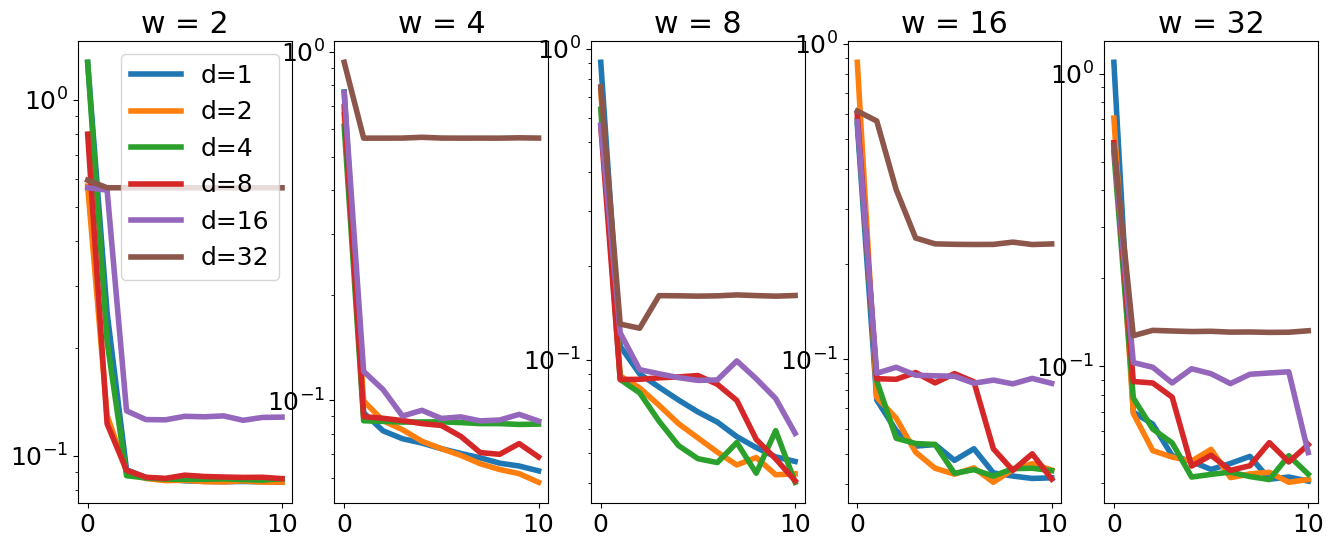

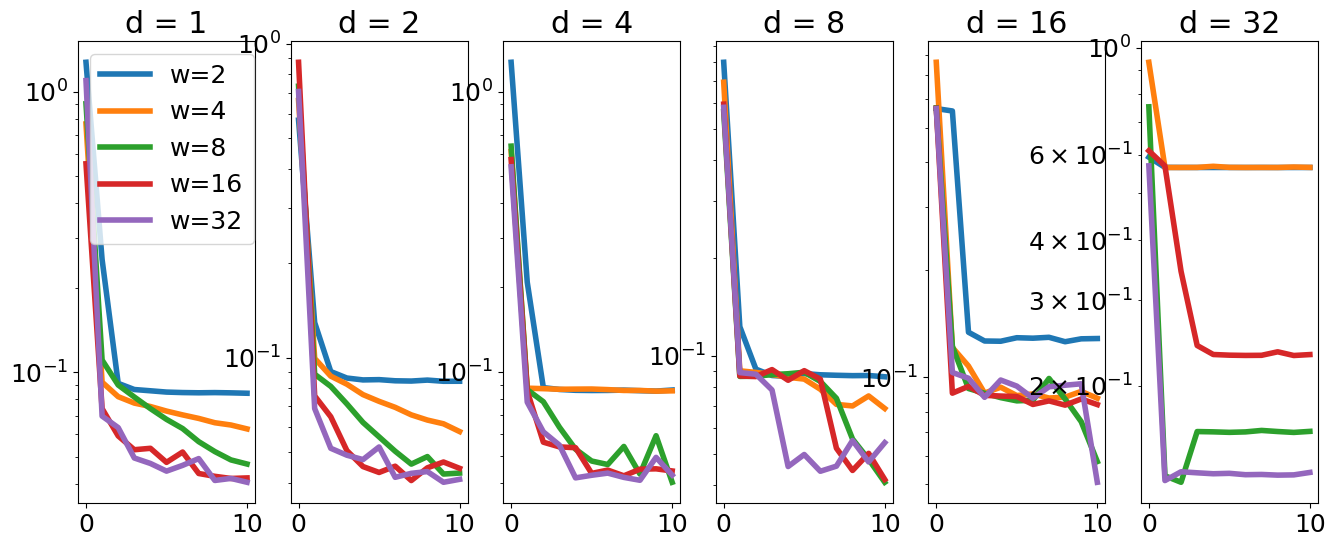

In [13]:
# plots of results

from copy import deepcopy
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (16, 6)
mpl.rcParams['font.size'] = 18
mpl.rcParams['lines.linewidth'] = 4

C_train = torch.zeros(len(widths), len(depths))
C_val = deepcopy(C_train)
for i in range(len(widths)):
  for j in range(len(depths)):
    C_train[i, j] = results[i, j][-1, 1]
    C_val[i, j] = results[i, j][-1, 2]


img = plt.imshow(torch.log(C_train), origin='lower')
cbar = plt.colorbar(img, fraction=0.046, pad=0.04)
cbar.ax.set_title('Final Loss (log scale)')
plt.xlabel('depth')
plt.xticks(ticks=[0, 1, 2, 3, 4, 5], labels=['$2^0$', '$2^1$', '$2^2$', '$2^3$', '$2^4$', '$2^5$'])
plt.ylabel('width')
plt.yticks(ticks=[0, 1, 2, 3, 4], labels=['$2^1$', '$2^2$', '$2^3$', '$2^4$', '$2^5$'])
plt.show()

img = plt.imshow(torch.log(C_val), origin='lower')
cbar = plt.colorbar(img, fraction=0.046, pad=0.04)
cbar.ax.set_title('Final Loss (log scale)')
plt.xlabel('depth')
plt.xticks(ticks=[0, 1, 2, 3, 4, 5], labels=['$2^0$', '$2^1$', '$2^2$', '$2^3$', '$2^4$', '$2^5$'])
plt.ylabel('width')
plt.yticks(ticks=[0, 1, 2, 3, 4], labels=['$2^1$', '$2^2$', '$2^3$', '$2^4$', '$2^5$'])
plt.show()

# plot convergence
for i, wi in enumerate(widths):
    plt.subplot(1, len(widths), i + 1)
    for j, dj in enumerate(depths):
        plt.semilogy(results[i, j][:, 1], label='d=%d' % dj)
    
    if i == 0:
        plt.legend()
    plt.title('w = %d' % wi)
plt.show()

for j, dj in enumerate(depths):
    plt.subplot(1, len(depths), j + 1)
    for i, wi in enumerate(widths):
        plt.semilogy(results[i, j][:, 1], label='w=%d' % wi)
      
    if j == 0:
        plt.legend()
        
    plt.title('d = %d' % dj)
plt.show()
